In [1]:
import pandas as pd
from sklearn.utils import shuffle

df = pd.read_pickle('https://pandora.infn.it/public/c7fce9/dl/dataset_pol_vbs_full2018v9_VBS_WW_2j_RDF_DNN_SigBkg.pkl')
pd.set_option('display.max_columns', None)

df['notLL'] = df['isTT'] + df['isMIX']
df['notTT'] = df['isLL'] + df['isMIX']

df_SvB = df[((df['isTT'] + df['isMIX'] + df['isLL']) == 0) & ((df['isVBS'] + df['isBKG']) == 1)]
df_SvB

,CleanJet_eta_1,CleanJet_eta_2,CleanJet_phi_1,CleanJet_phi_2,CleanJet_pt_1,CleanJet_pt_2,Lepton_eta_1,Lepton_eta_2,Lepton_phi_1,Lepton_phi_2,Lepton_pt_1,Lepton_pt_2,Rpt,Zepp_l1,Zepp_l2,Zepp_ll,detajj,detall,dphijj,dphilep1jet1,dphilep1jet2,dphilep1jj,dphilep2jet1,dphilep2jet2,dphilep2jj,dphill,dphilljet,dphilljetjet,dphillmet,dphilmet1,dphilmet2,dr_l1j1,dr_l1j2,dr_l2j1,dr_l2j2,drll,ht,m2ljj30,mT2,mTi,m_l1j1,m_l1j2,m_l2j1,m_l2j2,mcoll,mcollWW,mjj,mll,mtw1,mtw2,phi_miss,proxyW_l1,proxyW_l2,pt_miss,ptll,recoil,yll,isLL,isMIX,isTT,isBKG,isVBS,notLL,notTT
0,-2.805664,0.871460,-1.175293,-3.091797,115.945938,105.480812,-0.222351,1.390381,1.880859,2.354492,60.912807,42.632568,0.212335,0.744751,2.357483,1.551117,3.677124,1.612732,1.916504,3.056152,1.310529,2.335937,2.753400,0.836896,1.862304,0.473633,3.032799,2.141702,1.970499,1.776264,2.249897,4.001696,5.091536,5.483263,5.470954,1.680843,419.124969,985.871765,58.271770,158.066528,328.959351,136.063660,581.079773,68.985100,54.399845,170.509857,703.374695,94.460876,78.216949,76.092033,0.104595,79.019096,99.086594,41.708782,100.746727,92.839317,0.465608,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.510010,3.178711,-0.928223,0.462524,48.520248,43.383701,-0.576294,-0.817017,-3.005371,0.551392,109.715820,29.537357,1.539541,-1.410645,-1.651367,1.531006,4.688721,0.240723,1.390747,2.077148,2.815290,2.725920,1.479614,0.088867,0.830842,2.726423,2.220245,2.869017,2.640638,2.783735,0.057312,2.277360,5.111395,1.633860,3.996716,2.737029,309.260803,738.418823,35.363697,184.284683,144.914749,461.100403,58.736408,259.231140,139.885406,213.511795,478.232635,112.253952,137.038147,2.070315,0.494080,142.950180,30.416140,44.190891,83.541595,49.555382,-0.627577,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.062744,-2.286133,2.054688,2.298340,117.006165,31.059309,-0.268066,1.588379,-0.845337,-0.288269,41.428207,29.480330,0.336069,0.343628,2.200073,1.271851,3.348877,1.856445,0.243652,2.900024,3.139508,2.950902,2.342957,2.586609,2.393834,0.557068,2.669638,2.720516,0.750675,0.520289,1.077357,3.190799,3.735679,2.401195,4.658582,1.938224,279.125275,450.637604,26.961533,118.906151,171.348328,111.728691,114.258469,213.866852,162.401306,230.252060,311.639374,77.039307,25.680614,43.205353,-1.365626,28.976540,85.813622,60.151260,68.254791,119.503845,0.536568,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-3.285156,1.340576,1.058594,-1.453125,94.150909,43.804207,1.760498,-0.124847,-1.573730,-1.902832,32.677067,25.447952,0.201630,2.732788,0.847443,1.790115,4.625732,1.885345,2.511719,2.632324,0.120605,2.218511,2.961426,0.449707,2.547612,0.329102,2.776226,2.362412,1.936361,2.080262,1.751161,5.691024,0.436898,4.331004,1.532874,1.913854,249.244843,990.080811,49.173138,139.067184,695.389648,17.703999,248.063904,55.661476,22.814188,162.431519,654.367798,63.491798,71.896461,56.491291,2.629192,109.982231,56.677876,53.164700,57.352097,62.735786,0.909676,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-3.747070,1.243652,2.889648,-1.727295,64.973938,51.909889,1.294189,-0.332458,-0.136871,-2.426758,64.003830,21.561178,0.409156,2.545898,0.919250,1.732574,4.990723,1.626648,1.666242,3.026520,1.590424,2.545911,0.966779,0.699463,0.256025,2.289886,2.941757,2.231003,2.564538,2.249629,1.743670,5.879976,1.591226,6.318524,1.724347,2.808837,287.629669,1100.145630,26.790192,156.058716,807.220642,83.376167,202.906906,63.418484,61.674225,180.367538,705.582947,95.441437,90.914345,44.773403,2.112758,114.652504,45.826389,39.664787,52.377136,28.886316,0.827113,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226363,-0.581909,2.088379,-2.884766,0.785156,146.781616,83.524757,0.532593,-2.047852,-2.560547,-3.018066,93.853348,13.915641,0.106529,-0.220642,-2.801086,1.510864,2.670288,2.580444,2.613263,0.324219,2.937482,0.837788,0.133301,2.479963,0.380269,0.457520,0.266478,0.780047,2.8

In [2]:
import math
import numpy as np
import tensorflow as tf

In [3]:
import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, InputLayer
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import copy
print(tf.__version__)
from tensorflow.python.client import device_lib
tf.config.run_functions_eagerly(True)

2.7.0-rc1


In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

nclasses = 2
features = df.columns[:len(df.columns)-7]

NDIM = len(features)
print(NDIM)
for col in df.columns:
    df[col]    = np.hstack(df[col])
'''
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = shuffle(df)
'''
# Perform the splitting and define training and validation datasets
msk    = np.random.rand(len(df_SvB)) < 0.8

df_train    = df_SvB[msk]
df_val      = df_SvB[~msk]

X    = df_train.values[:,0:NDIM]
Y    = df_train[['isVBS', 'isBKG']].values
X_val = df_val.values[:,0:NDIM]
Y_val = df_val[['isVBS', 'isBKG']].values

print(X,Y)

57
[[-2.80566406e+00  8.71459961e-01 -1.17529297e+00 ...  1.00746727e+02
   9.28393173e+01  4.65607733e-01]
 [-1.51000977e+00  3.17871094e+00 -9.28222656e-01 ...  8.35415955e+01
   4.95553818e+01 -6.27577305e-01]
 [ 1.06274414e+00 -2.28613281e+00  2.05468750e+00 ...  6.82547913e+01
   1.19503845e+02  5.36567748e-01]
 ...
 [-7.98706055e-01  2.79541016e+00 -2.39941406e+00 ...  6.90503845e+01
   2.03726746e+02 -1.83842495e-01]
 [-5.29632568e-02 -2.61425781e+00  2.93701172e+00 ...  5.98092117e+01
   1.76484467e+02  3.13026577e-01]
 [ 2.38708496e-01 -3.43261719e+00 -5.46875000e-01 ...  1.08900810e+02
   9.90312500e+01 -1.49214625e+00]] [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [5]:
class SimpleNeuralNetwork ( tf.Module ):
    def __init__ (self, nEpochs, learning_rate, N_NODES, n_layers, n_features, n_outputsC=nclasses):
        self.learning_rate = learning_rate
        self.optimizer  = tf.optimizers.Adam (self.learning_rate)
        self.nEpochs = nEpochs
        self.N_NODES = N_NODES
        self.n_layers = n_layers
        self.n_features = n_features
        self.n_outputsC = n_outputsC
        self.weights = self.build (self.n_features, self.N_NODES)
        
                                
    # Define the structure of the model
    def build (self, n_input, N_NODES):
        # initializer = initializers.Ones()

        # Classifier model
        self.model1 = Sequential()
        self.model1.add(Dense (self.N_NODES, activation = 'relu', input_dim  = n_input))
        for i in range(self.n_layers):
            self.model1.add(Dense (self.N_NODES, activation = 'relu'))
        if self.n_outputsC > 1:
            self.model1.add(Dense (self.n_outputsC, activation = 'softmax',input_dim = self.N_NODES))
        else:
            self.model1.add(Dense (self.n_outputsC, activation = 'sigmoid',input_dim = self.N_NODES))
        
        return self.model1.weights
     
    # Performs the epochs loop and the actual training.
    # Monitors the training and validation loss functions, both for the classifier and the adversary.
    # Returns the classifier categorical accuracy.
    def fit (self, X, Y, X_val, Y_val, show_loss = False):
        losses = []
        losses_val = []

        self.means = np.mean ( X, axis = 0)
        self.sigmas = np.std ( X, axis = 0)

        for iEpoch in tqdm.tqdm(range(self.nEpochs)):
                l, l_val = self._train (X, Y, X_val, Y_val)
                losses.append ( l )
                losses_val.append ( l_val )

        losses = np.array(losses)               
        losses_val = np.array(losses_val)
               
        plt.plot (losses, color = "c", label='Training set')
        plt.plot (losses_val, color ='tab:blue', label = "Validation set")
        plt.xlabel ("Epoch"); plt.ylabel ("Loss")
        plt.legend(frameon=False)
        plt.show()
         
        ca = tf.keras.metrics.CategoricalAccuracy()
        if self.n_outputsC <= 1:
            ca = tf.keras.metrics.BinaryAccuracy()
        ca.update_state(Y, self.predict_proba(X))
        
        return ca.result().numpy()

    def save_weights(self, model_name):
        self.model1.save_weights(model_name+'_weights_1')
    
    def load_weights(self, model_name):
        self.model1.load_weights(model_name+'_weights_1')
        
    def save_model(self, model_name):
        self.model1.save("saved_models/"+model_name+"_1")

    def reset_optimizers(self):
        self.optimizer  = tf.optimizers.Adam (self.learning_rate)
        
    def set_epochs(self, epochs):
        self.nEpochs = epochs
        
    # Applies a pre-processing to the input features and returns the classifier representation.
    #@tf.function
    def predict_proba (self, X):
        ppX = (X - self.means)/self.sigmas
        return  tf.clip_by_value ( self.model1 (ppX) , 1e-7, 1. - 1e-7 )


    @tf.function
    def _train (self, X, Y, X_val, Y_val):
        Y_true = tf.cast (Y, tf.float32)
        Y_true_val = tf.cast (Y_val, tf.float32)

        with tf.GradientTape() as gt:
            #gt.watch ( self.weightsC )
            Y_hat = self.predict_proba (X)
            Y_hat_val = self.predict_proba (X_val) #N3(N1(x)) validation set
            
            ## Training set
            # Use the categorical cross-entropy as loss function for the classifier
            cce = 0.
            cce_val = 0.
            bce = 0.
            bce_val = 0.
            loss = 0.
            loss_val = 0.
            
            if self.n_outputsC > 1:
                cce = tf.keras.losses.CategoricalCrossentropy()
                loss = tf.reduce_mean ( cce( Y_true, Y_hat ) )
            
                ## Validation set
                cce_val = tf.keras.losses.CategoricalCrossentropy()
                loss_val = tf.reduce_mean (cce_val( Y_true_val, Y_hat_val ) )
            else:
                bce = tf.keras.losses.BinaryCrossentropy()
                loss = tf.reduce_mean ( bce( Y_true, Y_hat ) )
            
                ## Validation set
                bce_val = tf.keras.losses.BinaryCrossentropy()
                loss_val = tf.reduce_mean (bce_val( Y_true_val, Y_hat_val ) )
            
            # Compute the gradient of the overall loss with respect to the classifier weights
            gradients = gt.gradient ( loss, self.weights )

        # Apply the gradients
        self.optimizer.apply_gradients ( zip(gradients, self.weights) )
        
        return loss, loss_val

In [6]:
dnn = SimpleNeuralNetwork(1500, learning_rate=0.0001, N_NODES=50, n_layers=8, n_features=X.shape[1], n_outputsC=2)
dnn.save_weights("SigVsBkg_inclusive_RDF")

2023-04-27 10:20:52.349717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 10:20:52.359955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 10:20:52.360518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 10:20:52.362066: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
print(X.shape, Y.shape)
print(X)

(180960, 57) (180960, 2)
[[-2.80566406e+00  8.71459961e-01 -1.17529297e+00 ...  1.00746727e+02
   9.28393173e+01  4.65607733e-01]
 [-1.51000977e+00  3.17871094e+00 -9.28222656e-01 ...  8.35415955e+01
   4.95553818e+01 -6.27577305e-01]
 [ 1.06274414e+00 -2.28613281e+00  2.05468750e+00 ...  6.82547913e+01
   1.19503845e+02  5.36567748e-01]
 ...
 [-7.98706055e-01  2.79541016e+00 -2.39941406e+00 ...  6.90503845e+01
   2.03726746e+02 -1.83842495e-01]
 [-5.29632568e-02 -2.61425781e+00  2.93701172e+00 ...  5.98092117e+01
   1.76484467e+02  3.13026577e-01]
 [ 2.38708496e-01 -3.43261719e+00 -5.46875000e-01 ...  1.08900810e+02
   9.90312500e+01 -1.49214625e+00]]


100%|██████████| 1500/1500 [03:47<00:00,  6.60it/s]


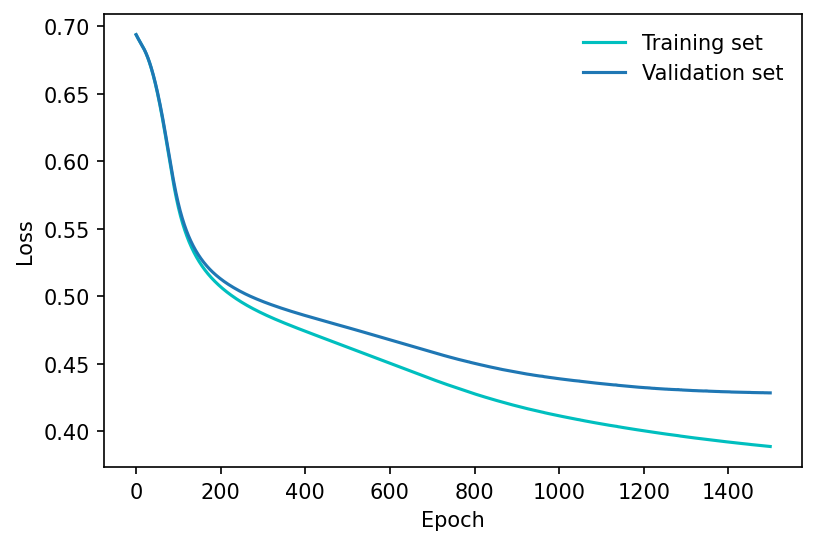

In [8]:
acc = dnn.fit (X.astype(np.float32), Y.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32))

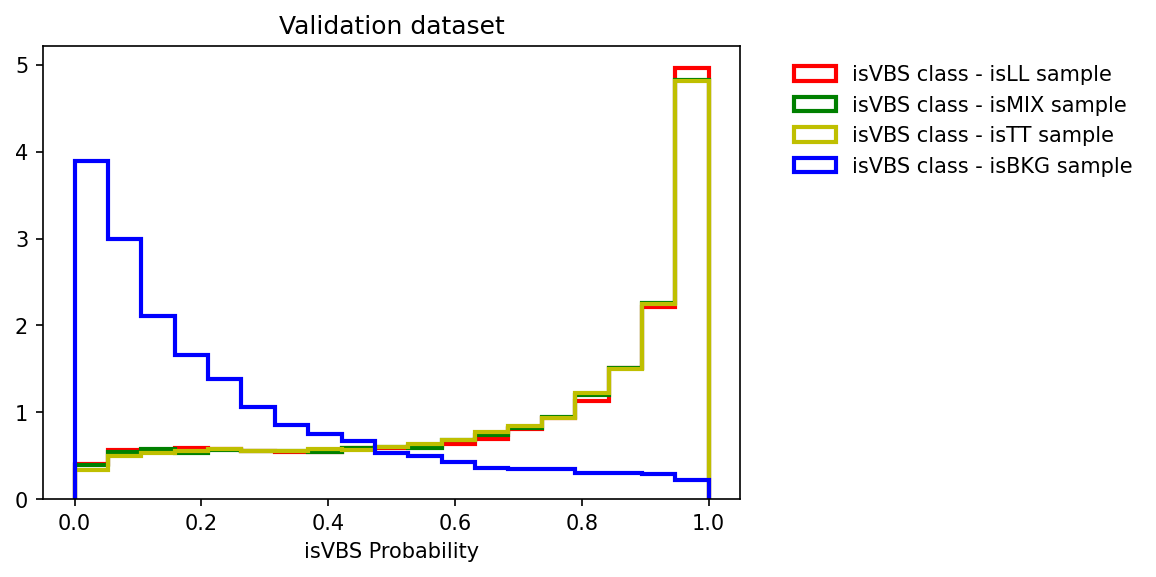

In [9]:
Y_predict_train = dnn.predict_proba(X)
Y_predict_val = dnn.predict_proba(X_val)

axis = np.linspace(0,1,20)

targets = ['isLL', 'isMIX', 'isTT', 'isBKG']
predictions = ['isVBS']
colors = ['r', 'g', 'y', 'b']
 
Y_targets = {}
Y_predictions = {}

for target in targets:
    #Y_targets[target] = dnn.predict_proba( df_val[ df_val[target]==1 ].values[:,0:NDIM] )
    if target != 'isBKG':
        Y_targets[target] = dnn.predict_proba( df[ df[target]==1 ].values[:,0:NDIM] )
    else:
        Y_targets[target] = dnn.predict_proba( df_val[ df_val[target]==1 ].values[:,0:NDIM] )
    Y_predictions[target] = {}
    for iprediction, prediction in enumerate(predictions):
        Y_predictions[target][prediction] = Y_targets[target][:,iprediction]

for prediction in predictions:
    for target, mycolor in zip(targets, colors):
        plt.hist(Y_predictions[target][prediction].numpy(), bins = axis, label = prediction + ' class - ' + target + ' sample', histtype='step', color=mycolor,  density=True, linewidth=2 )
    plt.title('Validation dataset')
    plt.xlabel(prediction + ' Probability')
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
    #plt.yscale('log')
    plt.show()

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#from matplotlib.backends.backend_pdf import PdfPages

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 16)
    plt.yticks(tick_marks, classes, fontsize = 16)

    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=10)

    plt.xlabel("Predicted label", fontsize=16)
    plt.ylabel("True label", fontsize=16)

    
    plt.tight_layout()

In [11]:
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, anderson_ksamp

X = df_val.values[:,0:NDIM]
Y_true = df_val[['isVBS', 'isBKG']].values
Y_pred = dnn.predict_proba(X)

# The classifier categorical accuracy is a good and simple metrics to evaluate the overall classification performance
Y_true_max = np.argmax(Y_true, axis=1)
Y_pred_max = np.argmax(Y_pred, axis=1)
print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))

Classifier categorical accuracy =  0.8057170542635659


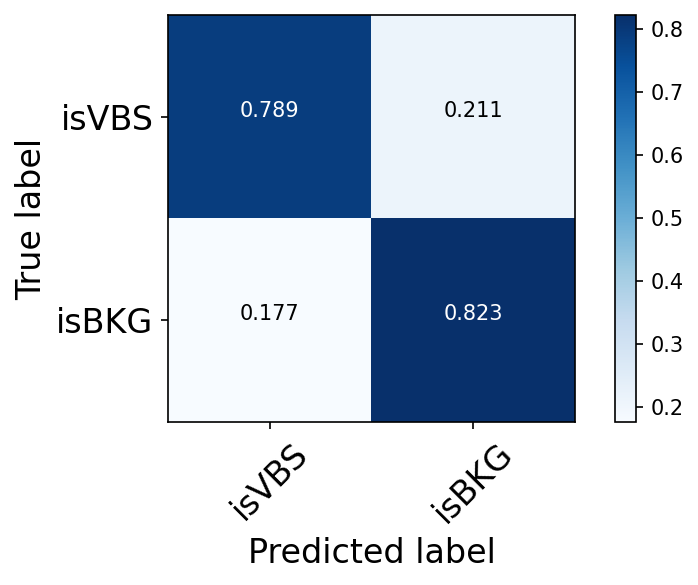

In [12]:
C = confusion_matrix(Y_true_max, Y_pred_max, normalize="true")
C = np.around(C, decimals=3)

plt.figure()
plot_confusion_matrix(C, classes=['isVBS', 'isBKG'], title='')
plt.show(1) 

In [13]:
X    = df.values[:,0:NDIM]
print(len(dnn.predict_proba(X)[...,0]))
df['DNN_SigVsBkg'] = dnn.predict_proba(X)[...,0].numpy().tolist()

339552


In [14]:
print(len(df))
print(len(df[(df['DNN_SigVsBkg'] > 0.5) & (df['isBKG'] == 1)]))
print(len(df[(df['DNN_SigVsBkg'] > 0.5) & (df['isLL'] == 1)]))
print(len(df[(df['DNN_SigVsBkg'] > 0.5) & (df['isMIX'] == 1)]))
print(len(df[(df['DNN_SigVsBkg'] > 0.5) & (df['isTT'] == 1)]))

df_other = df[((df['isTT'] + df['isMIX'] + df['isLL']) == 1) & (df['DNN_SigVsBkg'] > 0.5)]

df_notLL = df_other[df_other['notLL'] == 1].sample(n=int(len(df_other[df_other['notLL'] == 1])/2))
df_notTT= df_other[df_other['notTT'] == 1].sample(n=int(len(df_other[df_other['notTT'] == 1])/2))

df_LL = pd.concat([df_notLL, df_other[df_other['isLL'] == 1]])
df_TT = pd.concat([df_notTT, df_other[df_other['isTT'] == 1]])

339552
18284
27406
27523
27717


In [15]:
df_LL

,CleanJet_eta_1,CleanJet_eta_2,CleanJet_phi_1,CleanJet_phi_2,CleanJet_pt_1,CleanJet_pt_2,Lepton_eta_1,Lepton_eta_2,Lepton_phi_1,Lepton_phi_2,Lepton_pt_1,Lepton_pt_2,Rpt,Zepp_l1,Zepp_l2,Zepp_ll,detajj,detall,dphijj,dphilep1jet1,dphilep1jet2,dphilep1jj,dphilep2jet1,dphilep2jet2,dphilep2jj,dphill,dphilljet,dphilljetjet,dphillmet,dphilmet1,dphilmet2,dr_l1j1,dr_l1j2,dr_l2j1,dr_l2j2,drll,ht,m2ljj30,mT2,mTi,m_l1j1,m_l1j2,m_l2j1,m_l2j2,mcoll,mcollWW,mjj,mll,mtw1,mtw2,phi_miss,proxyW_l1,proxyW_l2,pt_miss,ptll,recoil,yll,isLL,isMIX,isTT,isBKG,isVBS,notLL,notTT,DNN_SigVsBkg
279930,1.948730,-1.152100,2.152344,-0.391846,238.503708,164.499878,0.423950,2.357910,-1.071533,-1.261475,66.220924,31.500835,0.053169,0.025635,1.959595,0.992615,3.100830,1.933960,2.544189,3.059308,0.679688,2.489528,2.869367,0.869629,2.679470,0.189941,2.998169,2.550667,1.009906,1.071045,0.881104,3.566278,1.716365,3.438253,3.616134,1.943265,625.949768,1137.874146,44.952393,215.422806,330.012756,195.353134,179.867294,408.681000,228.756363,301.332520,969.845703,103.117554,80.914803,46.636993,-2.142578,87.715462,167.570145,94.921799,97.337090,168.268509,1.118872,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.941570
287376,-2.280273,3.856445,-1.225830,-1.775635,59.308693,46.522602,0.136292,-1.343750,1.527344,-2.946777,138.006836,53.251049,2.663461,-0.651794,-2.131836,1.391815,6.136719,1.480042,0.549805,2.753174,2.980207,2.994014,1.720947,1.171143,1.480107,1.809064,3.138754,2.897914,2.888572,2.497314,1.976807,3.663298,4.974858,1.959269,5.330441,2.337357,351.003235,1467.143677,156.609711,279.940338,328.260834,527.151917,101.844894,668.830750,124.280159,204.343628,1127.862427,193.460602,163.642517,89.497078,-0.969971,164.064926,118.415771,53.914032,135.692810,84.579102,-0.317337,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.557299
296881,1.522217,-2.565918,-0.861084,-2.545898,208.827850,89.481506,-1.294678,-0.000244,2.051270,1.834717,97.576210,58.721107,0.306631,-0.772827,0.521607,0.125610,4.088135,1.294434,1.684814,2.912354,1.686017,2.950035,2.695801,1.902570,3.116598,0.216553,2.831094,3.031295,0.299398,0.380658,0.164105,4.051753,4.769697,3.096002,5.076660,1.312423,631.595032,1304.823608,7.453078,182.325638,618.549072,189.041229,285.899109,268.903717,253.809097,307.800171,1058.500854,106.235214,38.844948,13.055244,1.670612,147.601746,13.055248,108.020454,155.438736,260.608643,-0.790069,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.756732
313225,3.906738,-1.919434,-1.656738,1.102051,98.938171,84.391541,-1.693604,2.060059,0.733398,-1.852051,140.987076,25.763031,0.435024,-2.687256,1.066406,0.810425,5.826172,3.753662,2.758789,2.390137,0.368652,1.399395,0.195312,2.954102,1.186054,2.585449,2.276440,1.285699,3.139721,3.029767,0.667969,6.089054,0.432324,1.856979,4.956115,4.557908,545.140320,2633.947754,215.645706,600.400940,1947.891235,49.638767,109.065102,347.500366,357.533905,440.629669,1687.566406,401.582947,300.778870,42.214081,-2.520020,415.528259,162.937607,160.921402,119.880615,41.041615,-0.608448,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.984433
337598,2.383301,-2.875977,-1.389404,2.119141,118.524651,89.139381,0.882812,-1.516602,0.420105,-0.477295,32.782749,16.477949,0.051129,1.129150,-1.270264,0.070557,5.259277,2.399414,2.774640,1.809509,1.699036,2.545335,0.912109,2.596436,1.647935,0.897400,1.518837,2.254663,1.391693,1.101021,1.998420,2.350700,4.124950,4.005145,2.930764,2.561740,339.462921,1519.088379,26.618164,134.764969,143.575485,355.423462,307.582367,93.615479,110.806091,200.008820,1432.898682,72.982231,54.423107,62.033714,1.521126,72.188995,87.315178,82.538200,44.944496,100.768471,-0.033654,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.978351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264090,1.201660,-2.193848,-2.059082,0.651245,517.302185,172.586716,-0.036133,-1.137207,2.119629,0.318481,67.197662,65.866066,0.049575,0.459961,-0.6

In [16]:
for col in df.columns:
    df_LL[col] = np.hstack(df_LL[col])
    df_TT[col] = np.hstack(df_TT[col])
'''
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = shuffle(df)
'''
# Perform the splitting and define training and validation datasets
msk_LL = np.random.rand(len(df_LL)) < 0.8
msk_TT = np.random.rand(len(df_TT)) < 0.8

df_train_LL = df_LL[msk_LL]
df_train_TT = df_TT[msk_TT]
df_val_LL   = df_LL[~msk_LL]
df_val_TT   = df_TT[~msk_TT]

X_LL = df_train_LL.values[:,0:NDIM]
Y_LL = df_train_LL[['isLL', 'notLL']].values
#Y_LL = df_train_LL[['isLL']].values
X_val_LL = df_val_LL.values[:,0:NDIM]
Y_val_LL = df_val_LL[['isLL', 'notLL']].values
#Y_val_LL = df_val_LL[['isLL']].values

X_TT = df_train_TT.values[:,0:NDIM]
Y_TT = df_train_TT[['isTT', 'notTT']].values
#Y_TT = df_train_TT[['isTT']].values
X_val_TT = df_val_TT.values[:,0:NDIM]
Y_val_TT = df_val_TT[['isTT', 'notTT']].values
#Y_val_TT = df_val_TT[['isTT']].values

#X_val = df_val.values[:,0:NDIM+1]
#Y_val = df_val.values[:,NDIM+1:NDIM+1+nclasses] # isLL, isMIX, isTT, isBKG
print(X_LL,Y_LL)

[[  1.94873047  -1.15209961   2.15234375 ...  97.33708954 168.26850891
    1.1188724 ]
 [ -2.28027344   3.85644531  -1.22583008 ... 135.69281006  84.57910156
   -0.31733713]
 [  1.5222168   -2.56591797  -0.86108398 ... 155.43873596 260.60864258
   -0.79006892]
 ...
 [ -1.05761719   2.51367188   0.53759766 ...  38.23987961 113.74730682
   -0.67010307]
 [  3.56347656  -1.22802734   1.82275391 ...  75.6026001   39.3093071
    1.04318929]
 [  2.65429688  -3.86523438  -1.35083008 ...  72.81994629  19.16691589
   -0.52207154]] [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [17]:
dnnLL = SimpleNeuralNetwork(350, learning_rate=0.0001, N_NODES=50, n_layers=8, n_features=X_LL.shape[1], n_outputsC=2)
dnnLL.save_weights("LLvsOther_inclusive_RDF")

In [18]:
print(X_LL.shape, Y_LL.shape)

(43860, 57) (43860, 2)


100%|██████████| 350/350 [00:15<00:00, 23.31it/s]


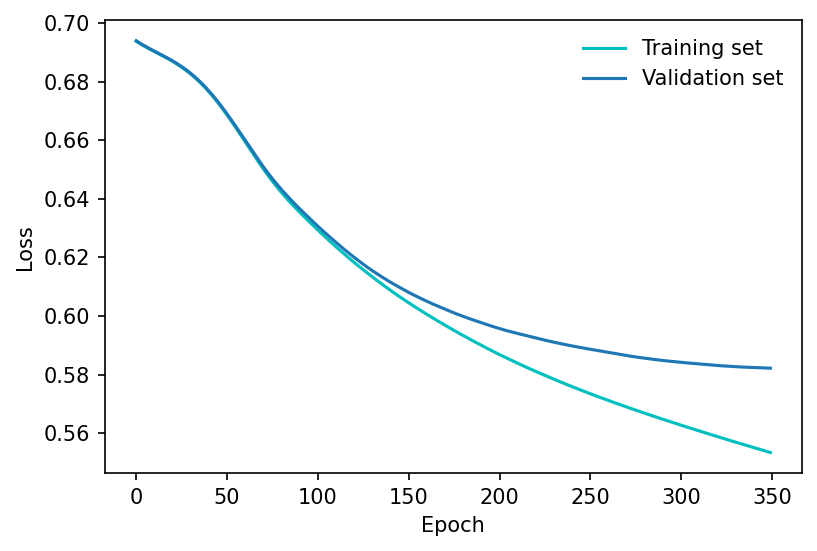

In [19]:
acc = dnnLL.fit (X_LL.astype(np.float32), Y_LL.astype(np.float32), X_val_LL.astype(np.float32), Y_val_LL.astype(np.float32))

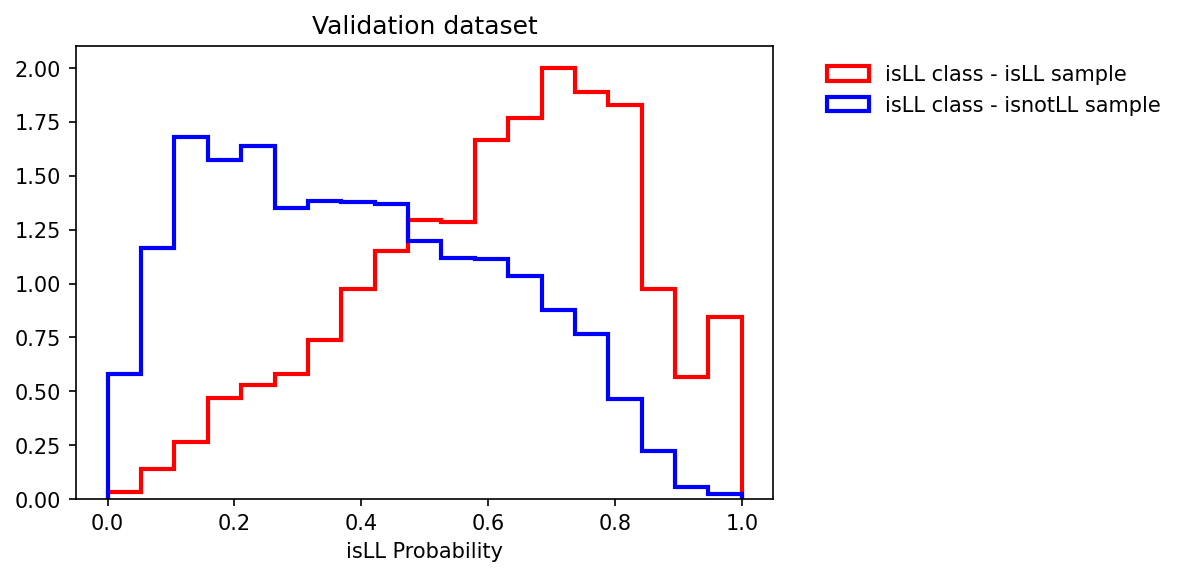

In [20]:
Y_predict_train_LL = dnnLL.predict_proba(X_LL)
Y_predict_val_LL = dnnLL.predict_proba(X_val_LL)

axis = np.linspace(0,1,20)

# targets = ['isLL', 'notLL']
# predictions = ['isLL']
# colors = ['r', 'b']
 
# Y_targets_LL = {}
# Y_predictions_LL = {}

# for target in targets:
#     Y_targets_LL[target] = dnnLL.predict_proba( df_val_LL[ df_val_LL[target]==1 ].values[:,0:NDIM] )
#     Y_predictions_LL[target] = {}
#     for iprediction, prediction in enumerate(predictions):
#         Y_predictions_LL[target][prediction] = Y_targets_LL[target][:,iprediction]

# for prediction in predictions:
#     for target, mycolor in zip(targets, colors):
#         plt.hist(Y_predictions_LL[target][prediction].numpy(), bins = axis, label = prediction + ' class - ' + target + ' sample', histtype='step', color=mycolor,  density=True, linewidth=2 )
#     plt.title('Validation dataset')
#     plt.xlabel('isLL Probability')
#     plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
#     #plt.yscale('log')
#     plt.show()

plt.hist(dnnLL.predict_proba( df_val_LL[ df_val_LL['isLL']==1 ].values[:,0:NDIM] ).numpy()[...,0], bins = axis, label = 'isLL class - isLL sample', histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(dnnLL.predict_proba( df_val_LL[ df_val_LL['isLL']==0 ].values[:,0:NDIM] ).numpy()[...,0], bins = axis, label = 'isLL class - isnotLL sample', histtype='step', color='b',  density=True, linewidth=2 )
plt.title('Validation dataset')
plt.xlabel('isLL Probability')
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
#plt.yscale('log')
plt.show()

In [21]:
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, anderson_ksamp

X_LL = df_val_LL.values[:,0:NDIM]
Y_true_LL = df_val_LL[['isLL', 'notLL']].values
Y_pred_LL = dnnLL.predict_proba(X_LL)

# The classifier categorical accuracy is a good and simple metrics to evaluate the overall classification performance
Y_true_max_LL = np.argmax(Y_true_LL, axis=1)
Y_pred_max_LL = np.argmax(Y_pred_LL, axis=1)
print("Classifier categorical accuracy = ", accuracy_score(Y_true_max_LL, Y_pred_max_LL))

Classifier categorical accuracy =  0.6912054451012001


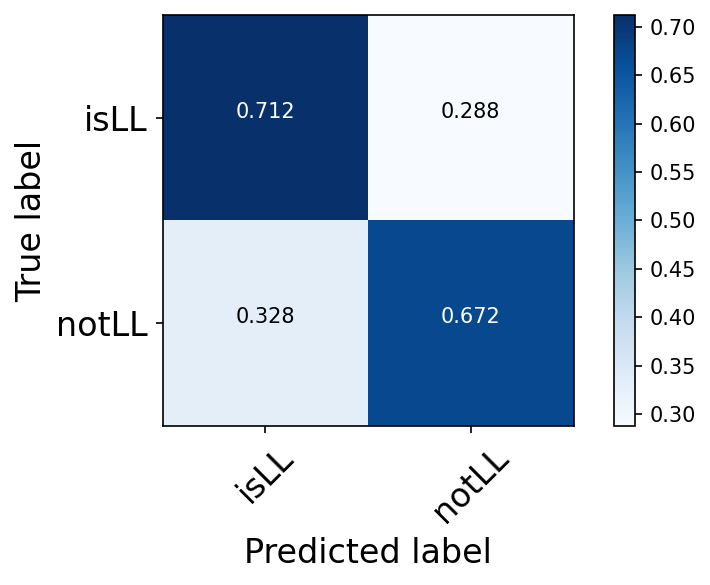

In [22]:
C = confusion_matrix(Y_true_max_LL, Y_pred_max_LL, normalize="true")
C = np.around(C, decimals=3)

plt.figure()
plot_confusion_matrix(C, classes=['isLL', 'notLL'], title='')
plt.show(1) 

In [23]:
dnnTT = SimpleNeuralNetwork(350, learning_rate=0.0001, N_NODES=50, n_layers=8, n_features=X_TT.shape[1], n_outputsC=2)
dnnTT.save_weights("TTvsOther_inclusive_RDF")

100%|██████████| 350/350 [00:15<00:00, 22.59it/s]


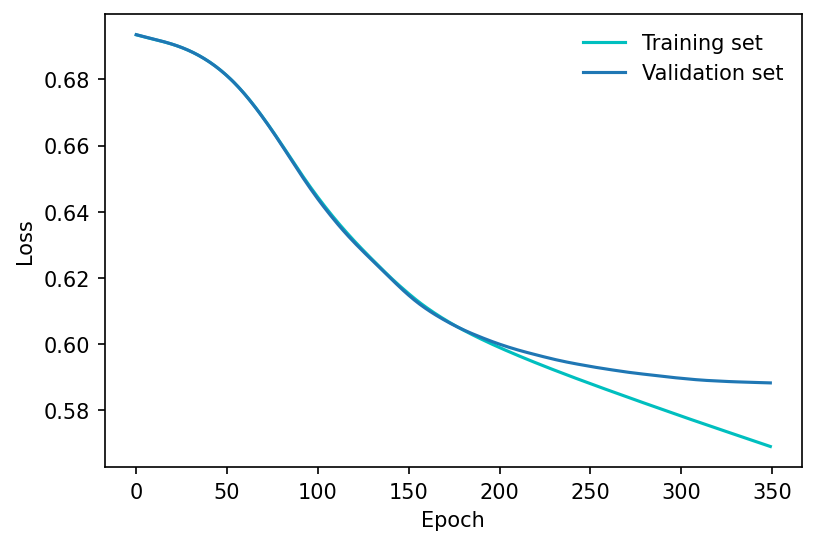

In [24]:
acc = dnnTT.fit (X_TT.astype(np.float32), Y_TT.astype(np.float32), X_val_TT.astype(np.float32), Y_val_TT.astype(np.float32))

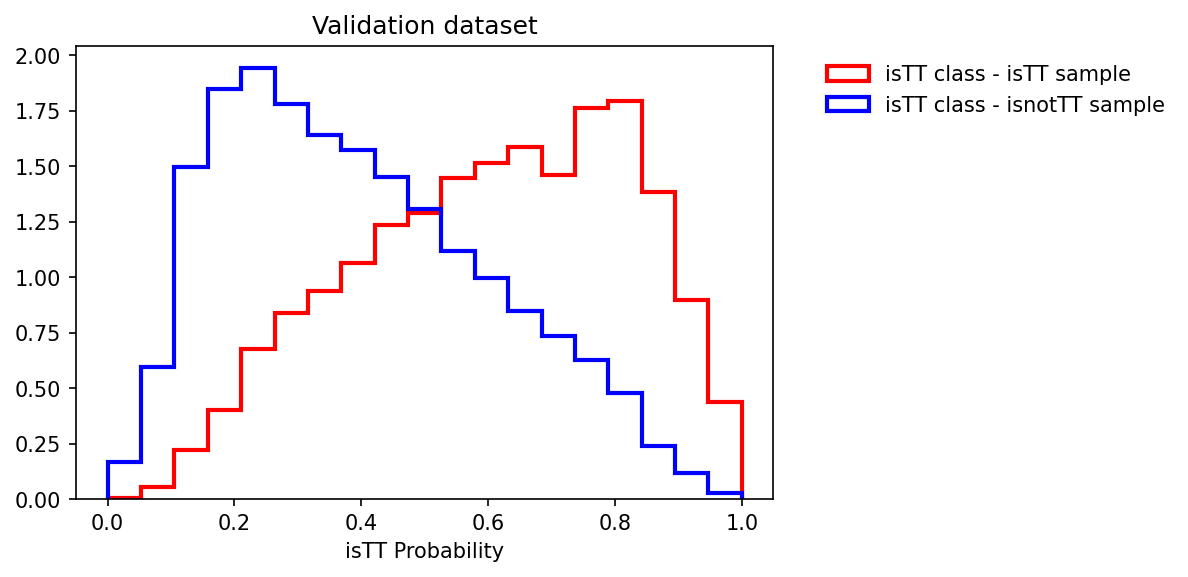

In [25]:
Y_predict_train_TT = dnnTT.predict_proba(X_TT)
Y_predict_val_TT = dnnTT.predict_proba(X_val_TT)

axis = np.linspace(0,1,20)

# targets = ['isTT', 'notTT']
# predictions = ['isTT', 'isnotTT']
# colors = ['r', 'b']
 
# Y_targets_TT = {}
# Y_predictions_TT = {}

# for target in targets:
#     Y_targets_TT[target] = dnnTT.predict_proba( df_val_TT[ df_val_TT[target]==1 ].values[:,0:NDIM] )
#     Y_predictions_TT[target] = {}
#     for iprediction, prediction in enumerate(predictions):
#         Y_predictions_TT[target][prediction] = Y_targets_TT[target][:,iprediction]

# for prediction in predictions:
#     for target, mycolor in zip(targets, colors):
#         plt.hist(Y_predictions_TT[target][prediction].numpy(), bins = axis, label = prediction + ' class - ' + target + ' sample', histtype='step', color=mycolor,  density=True, linewidth=2 )
#     plt.title('Validation dataset')
#     plt.xlabel(prediction + ' Probability')
#     plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
#     #plt.yscale('log')
#     plt.show()

plt.hist(dnnTT.predict_proba( df_val_TT[ df_val_TT['isTT']==1 ].values[:,0:NDIM] ).numpy()[...,0], bins = axis, label = 'isTT class - isTT sample', histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(dnnTT.predict_proba( df_val_TT[ df_val_TT['isTT']==0 ].values[:,0:NDIM] ).numpy()[...,0], bins = axis, label = 'isTT class - isnotTT sample', histtype='step', color='b',  density=True, linewidth=2 )
plt.title('Validation dataset')
plt.xlabel('isTT Probability')
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
#plt.yscale('log')
plt.show()

In [26]:
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, anderson_ksamp

X_TT = df_val_TT.values[:,0:NDIM]
Y_true_TT = df_val_TT[['isTT', 'notTT']].values
Y_pred_TT = dnnTT.predict_proba(X_TT)

# The classifier categorical accuracy is a good and simple metrics to evaluate the overall classification performance
Y_true_max_TT = np.argmax(Y_true_TT, axis=1)
Y_pred_max_TT = np.argmax(Y_pred_TT, axis=1)
print("Classifier categorical accuracy = ", accuracy_score(Y_true_max_TT, Y_pred_max_TT))

Classifier categorical accuracy =  0.6858638743455497


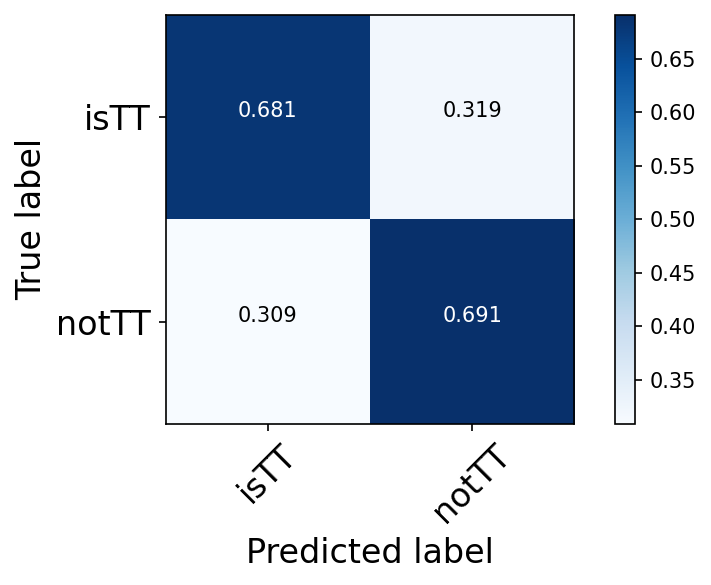

In [27]:
C = confusion_matrix(Y_true_max_TT, Y_pred_max_TT, normalize="true")
C = np.around(C, decimals=3)

plt.figure()
plot_confusion_matrix(C, classes=['isTT', 'notTT'], title='')
plt.show(1) 

In [28]:
print(len(dnnLL.predict_proba(X_val_LL)[...,0]))
print(len(dnnTT.predict_proba(X_val_LL)[...,0]))
df_val_LL['DNN_LL'] = dnnLL.predict_proba(X_val_LL)[...,0].numpy().tolist()
df_val_LL['DNN_TT'] = dnnTT.predict_proba(X_val_LL)[...,0].numpy().tolist()
print(df_val_LL)

11166
11166
        CleanJet_eta_1  CleanJet_eta_2  CleanJet_phi_1  CleanJet_phi_2  \
337598        2.383301       -2.875977       -1.389404        2.119141   
286129        0.843384       -2.560547       -0.956909       -1.310791   
270333       -2.679199        2.759766        0.014395        3.098145   
272966        1.907715       -4.047852       -2.846680       -1.485107   
284058        2.180176       -1.959961        0.479370        0.112045   
...                ...             ...             ...             ...   
264064       -2.783203        1.704102        2.445801       -2.129883   
264069       -2.909668        2.610352       -0.898071       -2.617676   
264072       -3.666992        1.599121       -0.727783        3.035645   
264073       -2.077637        2.407715       -1.190186        2.056152   
264075        1.647949       -1.532715        0.555176        0.346863   

        CleanJet_pt_1  CleanJet_pt_2  Lepton_eta_1  Lepton_eta_2  \
337598     118.524651      89.1

/tmp/ipykernel_519/3661036990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_LL['DNN_LL'] = dnnLL.predict_proba(X_val_LL)[...,0].numpy().tolist()
/tmp/ipykernel_519/3661036990.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_LL['DNN_TT'] = dnnTT.predict_proba(X_val_LL)[...,0].numpy().tolist()


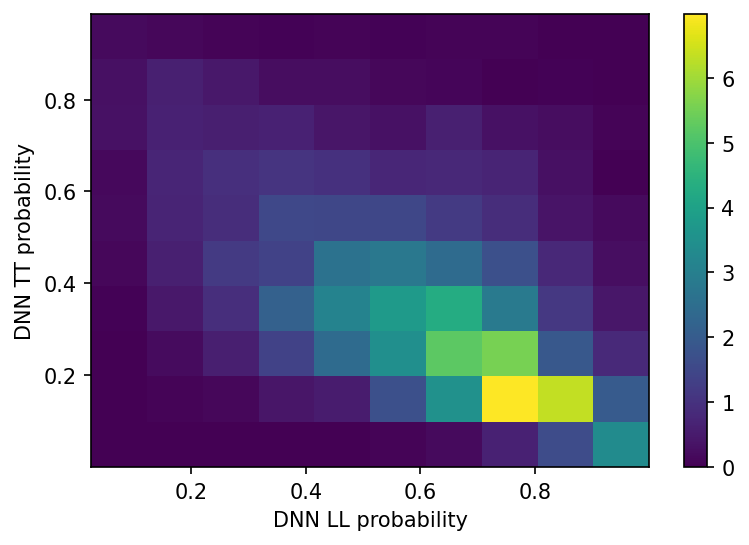

In [29]:
LL = df_val_LL[df_val_LL['isLL'] == 1]
mix = df_val_LL[df_val_LL['isMIX'] == 1]
TT = df_val_LL[df_val_LL['isTT'] == 1]

fig, ax = plt.subplots()
h_isLL = ax.hist2d(LL['DNN_LL'].values, LL['DNN_TT'].values, density=True)
fig.colorbar(h_isLL[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

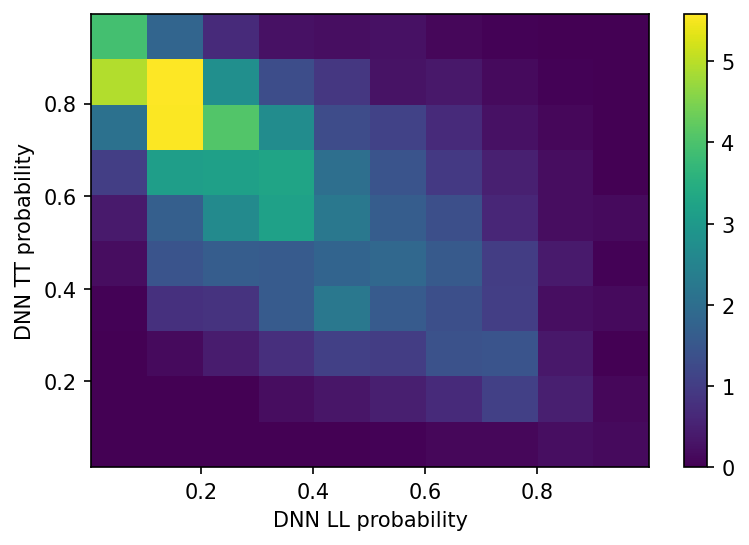

In [30]:
fig, ax = plt.subplots()
h_isTT = ax.hist2d(TT['DNN_LL'].values, TT['DNN_TT'].values, density=True)
fig.colorbar(h_isTT[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

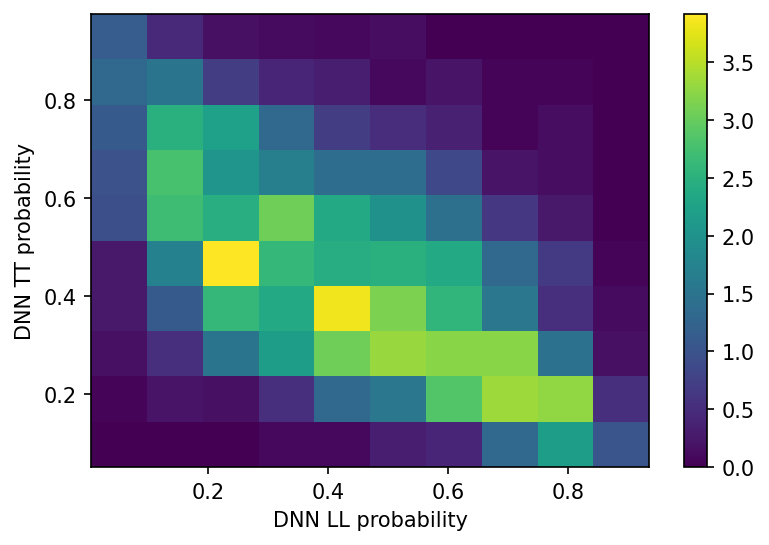

In [31]:
fig, ax = plt.subplots()
h_isMIX = ax.hist2d(mix['DNN_LL'].values, mix['DNN_TT'].values, density=True)
fig.colorbar(h_isMIX[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

/tmp/ipykernel_519/3595125263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_TT['DNN_LL'] = dnnLL.predict_proba(X_val_TT)[...,0].numpy().tolist()
/tmp/ipykernel_519/3595125263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_TT['DNN_TT'] = dnnTT.predict_proba(X_val_TT)[...,0].numpy().tolist()


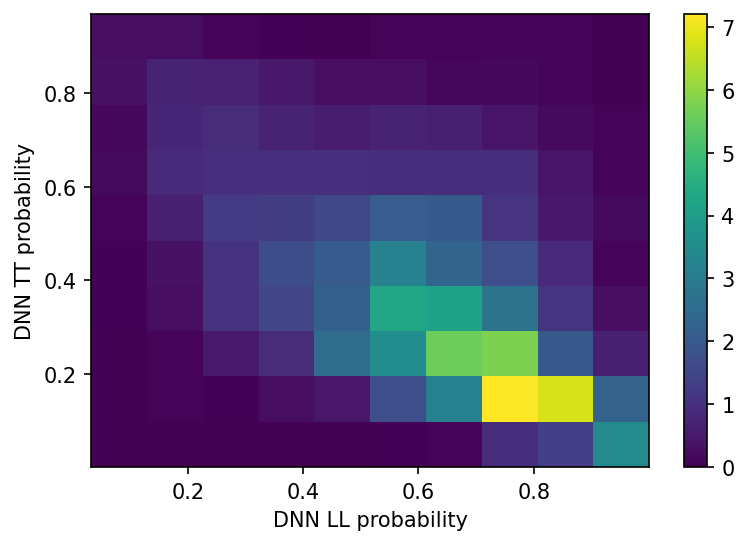

In [32]:
df_val_TT['DNN_LL'] = dnnLL.predict_proba(X_val_TT)[...,0].numpy().tolist()
df_val_TT['DNN_TT'] = dnnTT.predict_proba(X_val_TT)[...,0].numpy().tolist()

LL = df_val_TT[df_val_TT['isLL'] == 1]
mix = df_val_TT[df_val_TT['isMIX'] == 1]
TT = df_val_TT[df_val_TT['isTT'] == 1]

fig, ax = plt.subplots()
h_isLL = ax.hist2d(LL['DNN_LL'].values, LL['DNN_TT'].values, density=True)
fig.colorbar(h_isLL[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

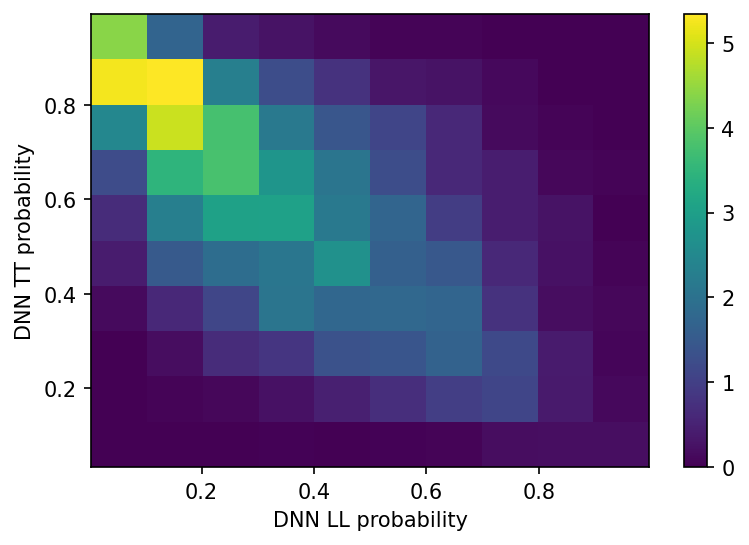

In [33]:
fig, ax = plt.subplots()
h_isTT = ax.hist2d(TT['DNN_LL'].values, TT['DNN_TT'].values, density=True)
fig.colorbar(h_isTT[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

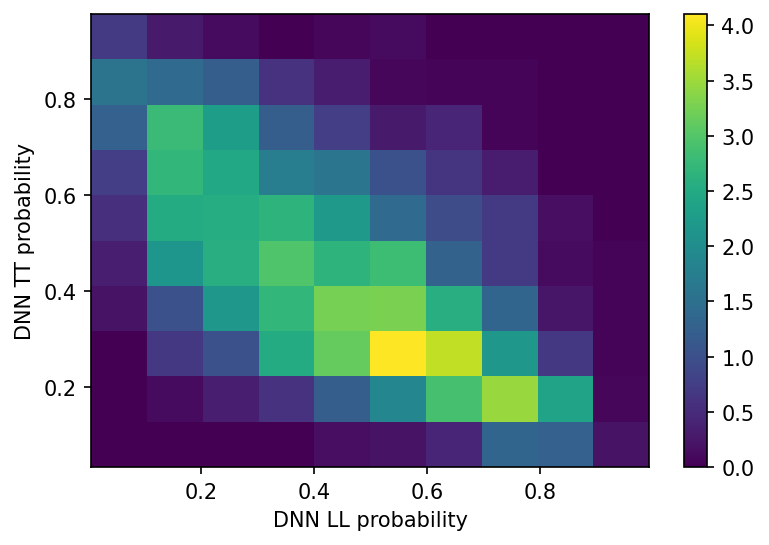

In [34]:
fig, ax = plt.subplots()
h_isMIX = ax.hist2d(mix['DNN_LL'].values, mix['DNN_TT'].values, density=True)
fig.colorbar(h_isMIX[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

In [35]:
with open('generated_code_dnn_SigVsBkg.h', 'w') as f:


    print ("""
    // Select all (Ctrl+A), Copy (Ctrl+C), paste to an empty text file (Ctrl+V) and save that file as 'generated_code.h'
    // 
    // Auto-generated header file. Assumes img to be a floating point array
    // of 64 elements (corresponding to an 8x8 b&w image)

    #include <math.h>

    float norma;
    """, file=f)
    
    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnn.model1.layers):
      print(type(layer))
#       if type(layer) is not Dropout and type(layer) is not Input :
      if type(layer) is Dense:
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1
        print ("inline float activation_%d (float x, float n) " % iLayer_tmp, file=f);
        activation =  layer.get_config()['activation'] 
        if activation == 'sigmoid':
          print ("{ return 1./(1 + exp(-x)); }", file=f)
        elif activation == 'tanh':
          print ("{ return tanh(x);}")
        elif activation == 'relu':
          print ("{ return x > 0 ? x : 0;}", file=f)
        elif activation == 'linear':
          print ("{ return x;}")
        elif activation == 'softmax':
          print ("{ return exp(x)/n;  }", file=f)
        else:
          raise KeyError ("Unexpected activation %s"%activation)
      
    iLayer_tmp=-1

    
    print ("""
    float guess_digit (const float *img, int flag)
    {
    """, file=f)

    max_out = 100
    for iLayer, layer in enumerate(dnn.model1.layers):
      if type(layer) is Dense:
        iLayer_tmp+=1
        print ("  // Declare the arrays in the stack", file=f)
        kernel, bias = layer.get_weights()
        
        print (type (dnn.means))
        print (type(bias))
        
         
        max_out = max(kernel.shape[1], max_out)
        #print ("  //",bias.shape)
        kernel_values = "{%s}"%(',\n   '.join(["{%s}"%(','.join(["%18.13f"%x for x in row])) for row in kernel]))
        bias_values   = "{%s}"% ( ",".join(["%18.13f"%x for x in bias]))
        print ("  const float kernel_%d[%d][%d] = \n  %s;" % (iLayer_tmp, kernel.shape[0], kernel.shape[1],kernel_values), file=f)
        print ("  const float bias_%d[%d] = %s;" % (iLayer_tmp, bias.shape[0], bias_values), file=f)
      
    print ("  float buffer_in[%d];" % max_out, file=f)
    print ("  float buffer_out[%d];" % max_out, file=f)

    print ("  unsigned int i,j,c; ", file=f)
    

    mean_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnn.means]))
    sigma_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnn.sigmas]))
    

    print (" float mean[%d] = %s;" % (max_out, mean_values), file=f)
    print (" float sigma[%d] = %s;" % (max_out, sigma_values), file=f)

    print ("\n\n\n", file=f)
    print ("  // Load the input in the buffer", file=f)
    print ("  for (c = 0; c < 64; ++c) \n  buffer_in[c] = (img[c]-mean[c])/sigma[c];", file=f)



    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnn.model1.layers):
      if type(layer) is Dense: 
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1

        if iLayer != len(dnn.model1.layers)-1:
            
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma = 0;

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_{iLayer_tmp}(buffer_out[c], norma);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
            
        else:
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma = 0;

            for(c=0;c<{n_out};++c)
              norma+=exp(buffer_out[c]);

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_{iLayer_tmp}(buffer_out[c], norma);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
      
    last_kernel, last_bias = dnn.model1.layers[-1].get_weights()
    print ("""
      //i = 0;
      //for (c = 0; c < {n_out}; ++c)
      //  if (buffer_in[c] > buffer_in[i])
      //    i = c;
      
      if (flag==0) //vbf
        return buffer_in[0];
      else if (flag==1) //bkg
        return buffer_in[1];
         
      
      //return i;
    """.format(n_out = last_kernel.shape[1]), file=f)

    print ("}", file=f)

<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [36]:
with open('generated_code_dnn_LLVsOther.h', 'w') as f:


    print ("""
    // Select all (Ctrl+A), Copy (Ctrl+C), paste to an empty text file (Ctrl+V) and save that file as 'generated_code.h'
    // 
    // Auto-generated header file. Assumes img to be a floating point array
    // of 64 elements (corresponding to an 8x8 b&w image)

    #include <math.h>

    float norma;
    """, file=f)
    
    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnnLL.model1.layers):
      print(type(layer))
#       if type(layer) is not Dropout and type(layer) is not Input :
      if type(layer) is Dense:
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1
        print ("inline float activation_%d (float x, float n) " % iLayer_tmp, file=f);
        activation =  layer.get_config()['activation'] 
        if activation == 'sigmoid':
          print ("{ return 1./(1 + exp(-x)); }", file=f)
        elif activation == 'tanh':
          print ("{ return tanh(x);}")
        elif activation == 'relu':
          print ("{ return x > 0 ? x : 0;}", file=f)
        elif activation == 'linear':
          print ("{ return x;}")
        elif activation == 'softmax':
          print ("{ return exp(x)/n;  }", file=f)
        else:
          raise KeyError ("Unexpected activation %s"%activation)
      
    iLayer_tmp=-1

    
    print ("""
    float guess_digit (const float *img, int flag)
    {
    """, file=f)

    max_out = 100
    for iLayer, layer in enumerate(dnnLL.model1.layers):
      if type(layer) is Dense:
        iLayer_tmp+=1
        print ("  // Declare the arrays in the stack", file=f)
        kernel, bias = layer.get_weights()
        
        print (type (dnnLL.means))
        print (type(bias))
        
         
        max_out = max(kernel.shape[1], max_out)
        #print ("  //",bias.shape)
        kernel_values = "{%s}"%(',\n   '.join(["{%s}"%(','.join(["%18.13f"%x for x in row])) for row in kernel]))
        bias_values   = "{%s}"% ( ",".join(["%18.13f"%x for x in bias]))
        print ("  const float kernel_%d[%d][%d] = \n  %s;" % (iLayer_tmp, kernel.shape[0], kernel.shape[1],kernel_values), file=f)
        print ("  const float bias_%d[%d] = %s;" % (iLayer_tmp, bias.shape[0], bias_values), file=f)
      
    print ("  float buffer_in[%d];" % max_out, file=f)
    print ("  float buffer_out[%d];" % max_out, file=f)

    print ("  unsigned int i,j,c; ", file=f)
    

    mean_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnnLL.means]))
    sigma_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnnLL.sigmas]))
    

    print (" float mean[%d] = %s;" % (max_out, mean_values), file=f)
    print (" float sigma[%d] = %s;" % (max_out, sigma_values), file=f)

    print ("\n\n\n", file=f)
    print ("  // Load the input in the buffer", file=f)
    print ("  for (c = 0; c < 64; ++c) \n  buffer_in[c] = (img[c]-mean[c])/sigma[c];", file=f)



    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnnLL.model1.layers):
      if type(layer) is Dense: 
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1

        if iLayer != len(dnnLL.model1.layers)-1:
            
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma = 0;

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_{iLayer_tmp}(buffer_out[c], norma);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
            
        else:
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma = 0;

            for(c=0;c<{n_out};++c)
              norma+=exp(buffer_out[c]);

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_{iLayer_tmp}(buffer_out[c], norma);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
      
    last_kernel, last_bias = dnnLL.model1.layers[-1].get_weights()
    print ("""
      //i = 0;
      //for (c = 0; c < {n_out}; ++c)
      //  if (buffer_in[c] > buffer_in[i])
      //    i = c;
      
      if (flag==0) //vbf
        return buffer_in[0];
      else if (flag==1) //bkg
        return buffer_in[1];
         
      
      //return i;
    """.format(n_out = last_kernel.shape[1]), file=f)

    print ("}", file=f)

<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [37]:
with open('generated_code_dnn_TTVsOther.h', 'w') as f:


    print ("""
    // Select all (Ctrl+A), Copy (Ctrl+C), paste to an empty text file (Ctrl+V) and save that file as 'generated_code.h'
    // 
    // Auto-generated header file. Assumes img to be a floating point array
    // of 64 elements (corresponding to an 8x8 b&w image)

    #include <math.h>

    float norma;
    """, file=f)
    
    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnnTT.model1.layers):
      print(type(layer))
#       if type(layer) is not Dropout and type(layer) is not Input :
      if type(layer) is Dense:
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1
        print ("inline float activation_%d (float x, float n) " % iLayer_tmp, file=f);
        activation =  layer.get_config()['activation'] 
        if activation == 'sigmoid':
          print ("{ return 1./(1 + exp(-x)); }", file=f)
        elif activation == 'tanh':
          print ("{ return tanh(x);}")
        elif activation == 'relu':
          print ("{ return x > 0 ? x : 0;}", file=f)
        elif activation == 'linear':
          print ("{ return x;}")
        elif activation == 'softmax':
          print ("{ return exp(x)/n;  }", file=f)
        else:
          raise KeyError ("Unexpected activation %s"%activation)
      
    iLayer_tmp=-1

    
    print ("""
    float guess_digit (const float *img, int flag)
    {
    """, file=f)

    max_out = 100
    for iLayer, layer in enumerate(dnnTT.model1.layers):
      if type(layer) is Dense:
        iLayer_tmp+=1
        print ("  // Declare the arrays in the stack", file=f)
        kernel, bias = layer.get_weights()
        
        print (type (dnnTT.means))
        print (type(bias))
        
         
        max_out = max(kernel.shape[1], max_out)
        #print ("  //",bias.shape)
        kernel_values = "{%s}"%(',\n   '.join(["{%s}"%(','.join(["%18.13f"%x for x in row])) for row in kernel]))
        bias_values   = "{%s}"% ( ",".join(["%18.13f"%x for x in bias]))
        print ("  const float kernel_%d[%d][%d] = \n  %s;" % (iLayer_tmp, kernel.shape[0], kernel.shape[1],kernel_values), file=f)
        print ("  const float bias_%d[%d] = %s;" % (iLayer_tmp, bias.shape[0], bias_values), file=f)
      
    print ("  float buffer_in[%d];" % max_out, file=f)
    print ("  float buffer_out[%d];" % max_out, file=f)

    print ("  unsigned int i,j,c; ", file=f)
    

    mean_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnnTT.means]))
    sigma_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnnTT.sigmas]))
    

    print (" float mean[%d] = %s;" % (max_out, mean_values), file=f)
    print (" float sigma[%d] = %s;" % (max_out, sigma_values), file=f)

    print ("\n\n\n", file=f)
    print ("  // Load the input in the buffer", file=f)
    print ("  for (c = 0; c < 64; ++c) \n  buffer_in[c] = (img[c]-mean[c])/sigma[c];", file=f)



    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnnTT.model1.layers):
      if type(layer) is Dense: 
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1

        if iLayer != len(dnnTT.model1.layers)-1:
            
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma = 0;

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_{iLayer_tmp}(buffer_out[c], norma);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
            
        else:
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma = 0;

            for(c=0;c<{n_out};++c)
              norma+=exp(buffer_out[c]);

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_{iLayer_tmp}(buffer_out[c], norma);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
      
    last_kernel, last_bias = dnnTT.model1.layers[-1].get_weights()
    print ("""
      //i = 0;
      //for (c = 0; c < {n_out}; ++c)
      //  if (buffer_in[c] > buffer_in[i])
      //    i = c;
      
      if (flag==0) //vbf
        return buffer_in[0];
      else if (flag==1) //bkg
        return buffer_in[1];
         
      
      //return i;
    """.format(n_out = last_kernel.shape[1]), file=f)

    print ("}", file=f)

<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
